In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from sklearn import manifold
from cs_systems.lstm_vae import RecurrentVariationalAutoEncoder

In [23]:
def create_ctable(characters):
    def encode(sequence):
        encoded_s = []
        for sc in sequence:
            enc = [1 if sc == c else 0 for i, c in enumerate(characters)]
            encoded_s.append(enc)

        return encoded_s

    def decode(sequence, calc_argmax=True):
        if calc_argmax:
            sequence = sequence.argmax(axis=-1)

        return [characters[i] for i in sequence]

    return encode, decode


def vectorize(data, encode):
    return np.array([encode(sequence) for sequence in data], dtype='float32')


def generate_data(size, timesteps, reverse=True):
    samples = []
    samples_reverse = []
    # -- one octave + equal amount of rests. 50/50 chance of rest?
    characters = [str(i) for i in range(24, 36)] + [' ' for _ in range(24, 36)]

    while len(samples) < size:
        notes = [random.randint(0, len(characters) - 1) for _ in range(timesteps)]
        tune = [characters[i] for i in notes]

        samples.append(tune)
        samples_reverse.append(tune[::-1])

    return samples, samples_reverse

In [24]:
characters = [' '] + [str(i) for i in range(24, 36)]
encode, decode = create_ctable(characters)

timesteps = 10
hidden_dims = [100, 30] 
latent_dim = 2

data, data_reverse = generate_data(50000, timesteps)
x = vectorize(data, encode)
x_reverse = vectorize(data_reverse, encode)

In [25]:
vae = RecurrentVariationalAutoEncoder(timesteps, len(characters), hidden_dims, latent_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer, loss='categorical_crossentropy')

In [26]:
history = vae.fit(x_reverse, x, epochs=25, batch_size=128)

Train on 50000 samples
Epoch 1/25
50000/50000 [==============================] - 19s 383us/sample - loss: 2.0075
Epoch 2/25
50000/50000 [==============================] - 15s 300us/sample - loss: 1.9392
Epoch 3/25
50000/50000 [==============================] - 15s 305us/sample - loss: 1.9388
Epoch 4/25
50000/50000 [==============================] - 15s 300us/sample - loss: 1.9387
Epoch 5/25
50000/50000 [==============================] - 16s 325us/sample - loss: 1.9387
Epoch 6/25
50000/50000 [==============================] - 17s 350us/sample - loss: 1.9386
Epoch 7/25
50000/50000 [==============================] - 15s 304us/sample - loss: 1.9386
Epoch 8/25
50000/50000 [==============================] - 15s 301us/sample - loss: 1.9386
Epoch 9/25
50000/50000 [==============================] - 17s 333us/sample - loss: 1.9387
Epoch 10/25
50000/50000 [==============================] - 18s 354us/sample - loss: 1.9386
Epoch 11/25
50000/50000 [==============================] - 16s 327us/sample 

In [27]:
# x_similar = [ 
#     ['24', ' ', ' ', '35', '27', ' ', '30', '30', ' ',  ' '],
#     ['24', ' ', ' ', '34', '27', ' ', '30', '30', ' ',  ' '],
#     ['24', ' ', ' ', '33', '27', ' ', '30', '30', ' ',  ' '],
#     ['24', ' ', ' ', '32', '27', ' ', '30', '30', ' ',  ' '],
#     ['24', ' ', ' ', '31', '27', ' ', '30', '30', ' ',  ' ']
# ]

# x_sim_vectorized = vectorize(x_similar, encode)
latent_representation = vae.encode(x_reverse[:1000])

In [28]:
mean, logvar, z = latent_representation

In [59]:
embedded_z = manifold.TSNE(n_components=2).fit_transform(z)

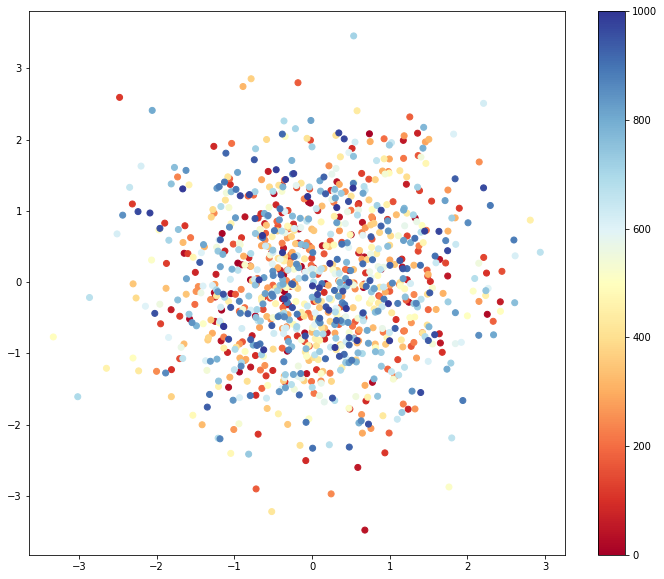

In [39]:
colors = np.linspace(0, 1000, num=len(z))

fig, ax = plt.subplots(1,1, figsize=(12, 10))
sc = ax.scatter(z[:, 0], z[:, 1], c=colors, cmap='RdYlBu')
plt.colorbar(sc)
plt.show()

In [33]:
distances = {}

for i, x1 in enumerate(z[:20]):
    for j, x2 in enumerate(z[:20]):
        if i == j:
            continue

        key = tuple(sorted((i, j)))

        if key in distances:
            continue
        else:
            dist = np.linalg.norm(x2-x1)

            # if dist < 1:
            distances[key] = dist

print(len(distances))

190


In [35]:
sorted_dists = sorted([(distances[k], k) for i, k in enumerate(distances)], key=lambda x: x[0])
sorted_dists[:10]

[(0.027797503, (3, 16)),
 (0.23062456, (1, 6)),
 (0.25805822, (6, 12)),
 (0.26044506, (8, 9)),
 (0.28586733, (0, 2)),
 (0.3169762, (2, 8)),
 (0.34042576, (10, 14)),
 (0.34109226, (13, 17)),
 (0.39458278, (4, 12)),
 (0.4148089, (1, 12))]

In [37]:
print(decode(x[3]))
print(decode(x[16]))

[' ', '24', ' ', ' ', ' ', ' ', '26', ' ', '30', ' ']
['34', ' ', '24', '34', ' ', ' ', '34', ' ', '28', '35']
